# Neural Collaborative Filtering
---

In [27]:
import pandas as pd
import numpy as np

# sklearn imports
from sklearn.model_selection import train_test_split
# visualization imports
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../src')

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
df_ratings = pd.read_csv('../Datasets/dataset/ydata-ymusic-user-artist-ratings-v1_0.txt', sep='\t',header=None, encoding="ISO-8859-1", names=['user_id', 'artist_id','ratings'])

In [5]:
df_ratings.replace(0, np.nan, inplace=True)
df_ratings.replace(255, 0, inplace=True)

In [6]:
df_ratings.dropna(inplace=True)

In [7]:
num_users = df_ratings.user_id.nunique()
num_items = df_ratings.artist_id.nunique()
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 1940250 unique users and 50080 unique movies in this data set


In [8]:
user_maxId = df_ratings.user_id.max()
item_maxId = df_ratings.artist_id.max()
print('There are {} distinct users and the max of user ID is also {}'.format(num_users, user_maxId))
print('There are {} distinct movies, however, the max of artist ID is {}'.format(num_items, item_maxId))

There are 1940250 distinct users and the max of user ID is also 1948882
There are 50080 distinct movies, however, the max of artist ID is 1101719


Pour des raisons de dimensions, on réindexe les ID des artistes

In [9]:
def reduce_item_dim(df_ratings):
    """
    Reduce item vector dimension to the number of distinct items in our data sets
    
    input: pd.DataFrame, df_ratings should have columns ['user_id', 'artist_id', 'ratings']
    output: pd.DataFrame, df_ratings with new 'artist_id' that is compressed
    """
    # pivot
    df_user_item = df_ratings.pivot(index='user_id', columns='artist_id', values='ratings')
    # reset movieId
    df_user_item = df_user_item.T.reset_index(drop=True).T
    # undo pivot/melt - compress data frame
    df_ratings_new = df_user_item \
        .reset_index('user_id') \
        .melt(
            id_vars='user_id', 
            value_vars=df_user_item.columns,
            var_name='artist_id',
            value_name='ratings')
    # drop nan and final clean up
    return df_ratings_new.dropna().sort_values(['user_id', 'artist_id']).reset_index(drop=True)

In [11]:
df_ratings.head()

,user_id,artist_id,ratings
0,1,178,90.0
1,1,5420,100.0
2,1,5910,90.0
3,1,5954,100.0
4,1,6004,100.0


In [10]:
df_ratings.artist_id = df_ratings.artist_id.astype('category').cat.codes
df_ratings.artist_id += 1
df_ratings.head()

,user_id,artist_id,ratings
0,1,178,90.0
1,1,5420,100.0
2,1,5910,90.0
3,1,5954,100.0
4,1,6004,100.0


In [12]:
df_train, df_test = train_test_split(df_ratings.head(10000), test_size=0.2, shuffle=True, random_state=99)
print('shape of training data set:')
print(df_train.shape)
print('shape of test data set:')
print(df_test.shape)

shape of training data set:
(8000, 3)
shape of test data set:
(2000, 3)


In [13]:
from NeuMF import NeuMF

NCF = NeuMF(num_users=num_users,
    num_items=num_items,
    MF_dim=10,
    MF_reg=(0, 0),
    MLP_layers=[64, 32, 16, 8],
    MLP_regs=[0, 0, 0, 0])

In [14]:
model_ncf = NCF.build_model()
model_ncf.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
mlp_user_embedding (Embedding)  (None, 1, 32)        62088032    user_input[0][0]                 
__________________________________________________________________________________________________
mlp_item_embedding (Embedding)  (None, 1, 32)        1602592     item_input[0][0]                 
______________________________________________________________________________________________

In [31]:
from NeuMF import Trainer

# model config
BATCH_SIZE = 64
EPOCHS = 10
VAL_SPLIT = 0.35

trainer = Trainer('adam', BATCH_SIZE, EPOCHS, VAL_SPLIT, inputs=[df_train.user_id.values, df_train.artist_id.values], outputs=df_train.ratings.values)
                      
history = trainer.train_model(model_ncf)

Train on 5200 samples, validate on 2800 samples
Epoch 1/10
5200/5200 [==============================] - 206s 40ms/sample - loss: 213.9094 - mean_squared_error: 213.9095 - rmse: 14.5275 - val_loss: 397.3089 - val_mean_squared_error: 397.3089 - val_rmse: 19.6238
Epoch 2/10
5200/5200 [==============================] - 199s 38ms/sample - loss: 205.1638 - mean_squared_error: 205.1638 - rmse: 14.1880 - val_loss: 404.5661 - val_mean_squared_error: 404.5661 - val_rmse: 19.8429
Epoch 3/10
5200/5200 [==============================] - 203s 39ms/sample - loss: 197.9641 - mean_squared_error: 197.9641 - rmse: 13.9111 - val_loss: 410.8807 - val_mean_squared_error: 410.8807 - val_rmse: 20.0214
Epoch 4/10
5200/5200 [==============================] - 175s 34ms/sample - loss: 192.5870 - mean_squared_error: 192.5870 - rmse: 13.7149 - val_loss: 414.9000 - val_mean_squared_error: 414.9001 - val_rmse: 20.1289
Epoch 5/10
5200/5200 [==============================] - 199s 38ms/sample - loss: 188.8083 - mean_squ

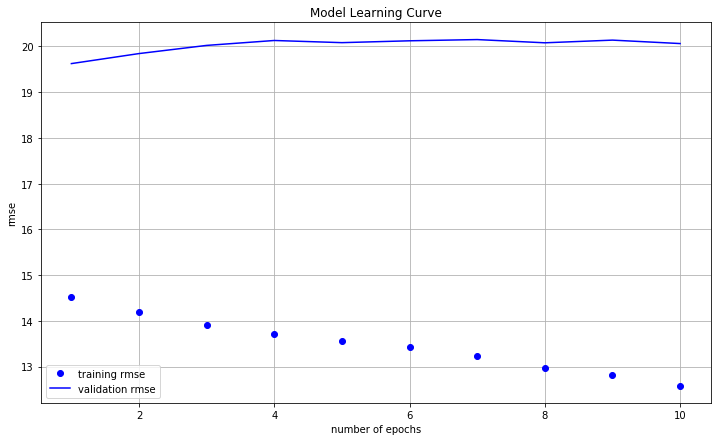

In [32]:
trainer.plot_learning_curve(history, 'rmse')

In [36]:
# define rmse function
rmse = lambda true, pred: np.sqrt(np.mean(np.square(np.squeeze(predictions) - np.squeeze(true))))

model_ncf_trained = trainer.load_trained_model(model_ncf, 'models/tmp/model.hdf5')

# make prediction using test data
predictions = model_ncf_trained.predict([df_test.user_id.values, df_test.artist_id.values])
# get the RMSE
error = rmse(df_test.ratings.values, predictions)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 21.7377
